In [59]:
from datetime import datetime as dt
import os
import subprocess
import serial
import time
import numpy as np
from win32gui import FindWindow, GetWindowRect
import win32gui
import win32api
import subprocess
import math
import numpy as np
%matplotlib qt5
from matplotlib import pyplot as plt
from matplotlib.path import Path
from pygame import mixer
import itertools
import random

In [70]:
class Motionstim8:

    """This is a class which provide an interface for sending messages to MotionStim8 device"""

    def __init__(self, freq):

        # The Motionstim8 device has a serial port
        self.serialPort = serial.Serial()

        # The default main stimulation frequency being used is 20 Hz
        self.stimulationFrequency = freq

        # The default group stimulation frequency being used is 50 Hz
        self.groupStimulationFrequency = 50

        # Set the N factor (0 by default)
        self.nFactor = 0

        # The number of channels in the FES device
        self.nChannels = 8

        # The device channel modes (singlets)
        self.pulseModes = [0] * self.nChannels

        # The device pulse widths
        self.pulseWidths = [300] * self.nChannels

        # The device amplitudes
        self.amplitudes = [0] * self.nChannels


    def OpenSerialPort(self, comPortName):
        # configure the serial connections (the parameters differs on the device you are connecting to)
        self.serialPort.port = comPortName
        self.serialPort.baudrate = 115200
        self.serialPort.parity = serial.PARITY_NONE
        self.serialPort.stopbits = serial.STOPBITS_ONE
        self.serialPort.bytesize = serial.EIGHTBITS
        self.serialPort.timeout = 500
        self.serialPort.write_timeout = 500
        self.serialPort.xonxoff  = False
        self.serialPort.rtscts = False
        self.dsrdtr = False

        # Open the port if not already opened
        if not self.serialPort.is_open:
            self.serialPort.open()

            
    def CloseSerialPort(self):

        # Close the serial port if it is open
        if self.serialPort.is_open:
            self.serialPort.close()


    def WriteFES(self, bitString):

        # Write a bitstring through the open serial port
        if self.serialPort.is_open:

            # Convert the bit string in to a bytes object
            byteString = int(bitString, 2).to_bytes(len(bitString) // 8, byteorder='big')
            bytesWritten = self.serialPort.write(byteString)
            self.serialPort.flush()

        else:
            print("Error writing to FES device: serial port not opened")


    # A method to initialize the device into Channel List Mode
    def InitializeChannelListMode(self):

        # Set ts1 and ts2
        ts1 = 1000  / self.stimulationFrequency
        ts2 = 1000 / self.groupStimulationFrequency

        # Compute the group and main times
        mainTime = int((ts1 - 1.0) / 0.5)
        groupTime = int((ts2 - 1.5) / 0.5)

        # Set the active channels according to the input
        activeChannelsString = "11111111"

        # Specify which channels apply the scaler to get lower frequencies (none by default)
        lowFrequencyChannelsString = "00000000"

        # Compute checksum
        checksum = (self.nFactor + int(activeChannelsString) + int(lowFrequencyChannelsString) + groupTime + mainTime) % 8

        # Convert each parameter to its correct binary representation
        mainTimeBinary = "{0:011b}".format(mainTime)                              # binary, 11 bit width, 0 padding
        nFactorBinary = "{0:03b}".format(self.nFactor)                                 # binary, 3 bit width, 0 padding
        groupTimeBinary = "{0:05b}".format(groupTime)                             # binary, 5 bit width, 0 padding
        checksumBinary = "{0:03b}".format(checksum)                               # binary, 3 bit width, 0 padding

        # Compose the complete bistring
        bitString = "100"\
                    + checksumBinary\
                    + nFactorBinary[0:2]\
                    + "0"\
                    + nFactorBinary[2:3]\
                    + activeChannelsString[0:6]\
                    + "0"\
                    + activeChannelsString[6:8]\
                    + lowFrequencyChannelsString[0:5]\
                    + "0"\
                    + lowFrequencyChannelsString[5:8]\
                    + "00"\
                    + groupTimeBinary[0:2]\
                    + "0"\
                    + groupTimeBinary[2:5]\
                    + mainTimeBinary[0:4]\
                    + "0"\
                    + mainTimeBinary[4:11]

        # Write the bit string
        self.WriteFES(bitString)


    def UpdateChannelSettings(self, newAmplitudes, newPulses, pulseModes):

        # Ensure that the device amplitudes are capped between the safety bounds 0 - 50 mA
        for index, amplitude in enumerate(newAmplitudes):

            if amplitude > 50:

                self.amplitudes[index] = 50

            elif amplitude < 0:

                self.amplitudes[index] = 0

            else:

                self.amplitudes[index] = newAmplitudes[index]
                
        for i, pulse in enumerate(newPulses):
            self.pulseWidths[i] = pulse
        
        
        for i, mode in enumerate(pulseModes):
            self.pulseModes[i] = mode
#         for i, freq in enumera?te(newFreqs):
#         self.stimulationFrequency = newFreq
        
            
        # Compute checksum
        checksum = (np.sum(self.pulseModes) + np.sum(self.pulseWidths) + np.sum(self.amplitudes)) % 32

        # Construct the channel settings string
        checksumBinary = "{0:05b}".format(checksum)

        channelSettingsBinary = ""
        for amplitude, pulseWidth, pulseMode in zip(self.amplitudes, self.pulseWidths, self.pulseModes):

            pulseWidthBinary = "{0:09b}".format(pulseWidth)
            channelSettingBinary = "0"\
                                   + "{0:02b}".format(pulseMode)\
                                   + "000"\
                                   + pulseWidthBinary[0:2]\
                                   + "0"\
                                   + pulseWidthBinary[2:9]\
                                   + "0"\
                                   + "{0:07b}".format(amplitude)

            channelSettingsBinary += channelSettingBinary

        # Compose the final bitstring
        bitString = "101" + checksumBinary + channelSettingsBinary

        # Write the bit string
        self.WriteFES(bitString)


    def StopDevice(self):

        # Compose the stop command
        stopCommandBinary = "11000000"

        # Write the bit string
        self.WriteFES(stopCommandBinary)

In [3]:
WIN_SIZE = [1920, 1100]
WIN_CENTER = (WIN_SIZE[0] // 2, WIN_SIZE[1] // 2)

def gen_mask(num_verts, figure_radius, figure_center, first_angle, wm_size):
    wm_size[0], wm_size[1] = wm_size[1], wm_size[0]
    angles = [[np.cos(theta), np.sin(theta)] 
              for theta in np.linspace(first_angle, 
                                       first_angle+2*np.pi, 
                                       num_verts+1)]

    verts = np.array(angles)*figure_radius
    verts[:, 0] = verts[:, 0] + figure_center[0]
    verts[:, 1] = verts[:, 1] + figure_center[1]
    poly_path=Path(verts)
    x, y = np.mgrid[:WIN_SIZE[0], :WIN_SIZE[1]]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1, 1))) # coors.shape is (4000000,2)

    mask = poly_path.contains_points(coors).reshape(wm_size[0], wm_size[1])
    wm_size[1], wm_size[0] = wm_size[0], wm_size[1]
    return mask, verts

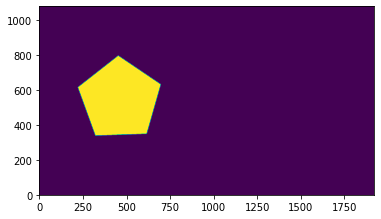

In [63]:
%matplotlib inline

#Choose randomly number of vertex 
num_verts=np.random.choice([4 ,5, 22])
figure_radius=250

#Choose randomly number of vertex 
# bot = 350 top = 700
first_angle = np.random.rand() * np.pi
figure_mask, figure_verts = gen_mask(num_verts,
                       figure_radius,
                       figure_center=[np.random.randint(350, 700), np.random.randint(figure_radius+100, WIN_SIZE[0]-figure_radius-100)],
                        # figure_center=[700, 800],
                       first_angle=first_angle,
                       wm_size=WIN_SIZE)

fig, ax = plt.subplots()
ax.imshow((figure_mask))
ax.set_xlim((0, 1920))
ax.set_ylim((0, 1080))
plt.show()

In [76]:
# Initialize audio stimuli
mixer.init()
mixer.music.load("resources/1khz.mp3")


# Initialize stimulation by electrical
try:
    mm=Motionstim8(freq=10)
    mm.OpenSerialPort('COM3')
    mm.InitializeChannelListMode()
except:
    raise Exception('Unable to open serial port for MotionStim8 connection!\nTry to check MotionStim8 port or reboot kernel.')
Pulses=150
pulseModes=0
print('Input peak stimulation which will be provided inside target area')
peak_amp = int(input())
print('Input baseline stimulation which will be provided outside target area')
baseline_stim = int(input())
stim_amp = peak_amp - baseline_stim

# We declare 12 trials for each of stimuli and 4 per each figure type
trials = 4 * [('a', 4), ('a', 5), ('a', 22)] + 4 * [('s', 4), ('s', 5), ('s', 22)]
random.shuffle(trials)

Input peak stimulation which will be provided inside target area


 5


Input baseline stimulation which will be provided outside target area


 2


23-03-06_14-08-22


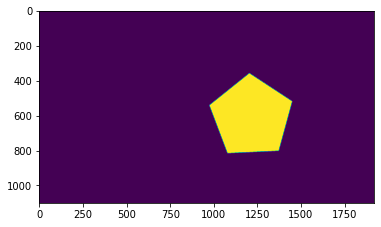

Press Enter to start trial


Trial has crushed. Repeating...


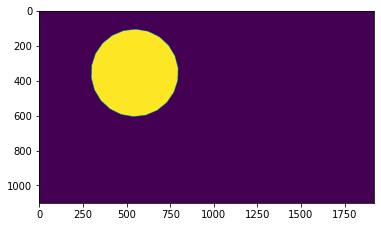

Press Enter to start trial


Trial has crushed. Repeating...


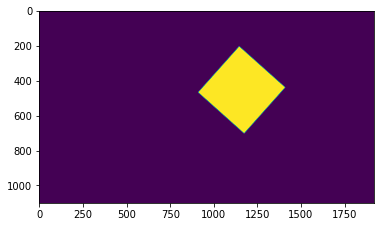

Press Enter to start trial


Trial has crushed. Repeating...


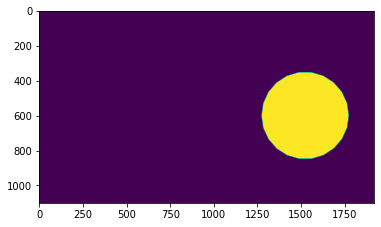

Press Enter to start trial


Trial has crushed. Repeating...


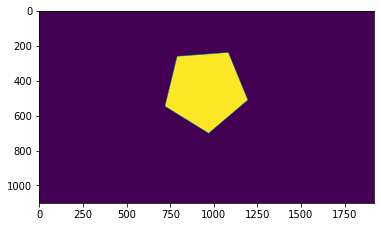

Press Enter to start trial


Trial has crushed. Repeating...


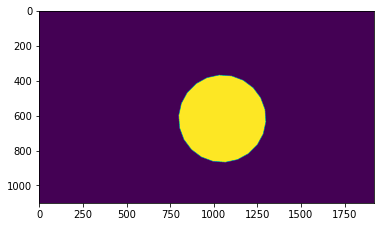

Press Enter to start trial


Time spent on trial: 32.09688878059387 sec


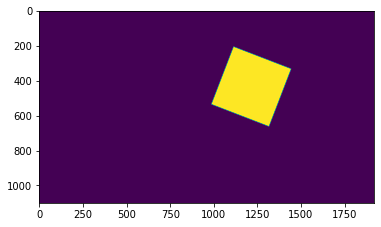

Press Enter to start trial


KeyboardInterrupt: Interrupted by user

In [84]:
time_label = dt.now().strftime('%y-%m-%d_%H-%M-%S')
print(time_label)

toggle = 0
toggle_prev = 0;
crushed_trials = []
for trial, fig_type in trials:
    # Generate mask
    first_angle = np.random.rand() * np.pi
    figure_mask, figure_verts = gen_mask(fig_type,
                           figure_radius,
                           figure_center=[np.random.randint(350, 700), np.random.randint(figure_radius+100, WIN_SIZE[0]-figure_radius-100)],
                           first_angle=first_angle,
                           wm_size=WIN_SIZE)
    plt.imshow((figure_mask))
    plt.savefig(os.path.join('session', time_label + '_figure_mask.png'), dpi=300)
    plt.show()
    session_log_filename = os.path.join('session', time_label + '_session.log')
    print('Press Enter to start trial')
    input()
    start = time.time()
    
    try:
        while True:
            x = win32api.GetCursorPos()[0]
            y = WIN_SIZE[1] - win32api.GetCursorPos()[1]
            if (y > 0) & (x > 0):
                toggle = figure_mask[y, x]
                if toggle!=toggle_prev:
                    toggle_prev = toggle
                    if trial == 'a' and toggle == True:
                        mixer.music.play()
                    elif trial == 'a' and toggle == False:
                        mixer.music.stop()
                    else:
                        st=toggle*stim_amp+baseline_stim
                        mm.UpdateChannelSettings(newAmplitudes=[st], newPulses=[150], pulseModes=[0])
    except KeyboardInterrupt:
        print(f'Time spent on trial: {time.time() - start} sec')
    except IndexError:
        print(f'Trial has crushed. Repeating...')
        crushed_trials.append((trial, fig_type))

In [33]:
mixer.music.stop()

In [72]:
mm.StopDevice()

In [ ]:
cmd = r'adb shell getevent -t /dev/input/event2'

In [8]:
for l in p1.stdout:
    line = l.decode(encoding="utf-8", errors="ignore").strip()
    print(line)

[   69997.341163] 0000 0002 00000000
[   69997.341163] 0000 0000 00000000
[   69997.358275] 0001 014a 00000001
[   69997.358275] 0003 0035 0000041c
[   69997.358275] 0003 0036 0000017f
[   69997.358275] 0003 0039 00000001
[   69997.358275] 0000 0002 00000000
[   69997.358275] 0000 0000 00000000
[   69997.375137] 0003 0035 0000041c
[   69997.375137] 0003 0036 0000017f
[   69997.375137] 0003 0039 00000001
[   69997.375137] 0000 0002 00000000
[   69997.375137] 0000 0000 00000000
[   69997.391139] 0003 0035 0000041c
[   69997.391139] 0003 0036 0000017f
[   69997.391139] 0003 0039 00000001
[   69997.391139] 0000 0002 00000000
[   69997.391139] 0000 0000 00000000
[   69997.408051] 0003 0035 00000412
[   69997.408051] 0003 0036 0000017f
[   69997.408051] 0003 0039 00000001
[   69997.408051] 0000 0002 00000000
[   69997.408051] 0000 0000 00000000
[   69997.425360] 0003 0035 00000406
[   69997.425360] 0003 0036 0000017f
[   69997.425360] 0003 0039 00000001
[   69997.425360] 0000 0002 00000000
[

KeyboardInterrupt: 

In [ ]:
p1.stdout:

In [85]:
crushed_trials

[('s', 5), ('a', 22), ('a', 4), ('s', 22), ('a', 5)]